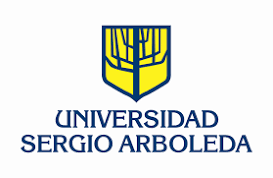

Udacity-cs344 HW3

Computación Paralela y distribuida

* Santiago Niño
* Esteban Rodriguez
* Daniel Velasquez

Abril 2023

In [ ]:
# Homework 3 for Udacity CS344 Course, Intro to Parallel Programming
# clone the code repo,
!git clone https://github.com/depctg/udacity-cs344-colab
!pip install git+https://github.com/depctg/nvcc4jupyter.git

# load cuda plugin
%config NVCCPluginV2.static_dir = True
%config NVCCPluginV2.relative_dir = "udacity-cs344-colab/src/HW3"
%load_ext nvcc_plugin

# change to work directory, generate makefiles
!mkdir udacity-cs344-colab/build
%cd udacity-cs344-colab/build
!cmake ../src

Cloning into 'udacity-cs344-colab'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 144 (delta 14), reused 12 (delta 12), pack-reused 120
Receiving objects: 100% (144/144), 3.93 MiB | 13.99 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/depctg/nvcc4jupyter.git to /tmp/pip-req-build-q_am7_ix
  Running command git clone --filter=blob:none --quiet https://github.com/depctg/nvcc4jupyter.git /tmp/pip-req-build-q_am7_ix
  Resolved https://github.com/depctg/nvcc4jupyter.git to commit 63b811d987446c2a3783845b7b85cda6e562b71a
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4333 sha256=fd1c0366406d51e27b1750643e05f259a1489524ddae6cffc7f6e388ca42e783
  Stored in directory: /tmp/pip-ephem-wheel-

In [ ]:
makefiletemp = open('../src/CMakeLists.txt','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[23] = "-Wno-deprecated-gpu-targets \n"

makefiletemp = open('../src/CMakeLists.txt','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
makefiletemp = open('../build/HW3/CMakeFiles/HW3.dir/HW3_generated_student_func.cu.o.cmake','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[75] = "-Wno-deprecated-gpu-targets \n"

makefiletemp = open('../build/HW3/CMakeFiles/HW3.dir/HW3_generated_student_func.cu.o.cmake','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
makefiletemp = open('../build/HW3/CMakeFiles/HW3.dir/HW3_generated_student_func.cu.o.cmake.pre-gen','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[75] = "-Wno-deprecated-gpu-targets \n"

makefiletemp = open('../build/HW3/CMakeFiles/HW3.dir/HW3_generated_student_func.cu.o.cmake.pre-gen','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
makefiletemp = open('../src/HW3/loadSaveImage.cpp','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[16] = "cv::Mat originImg = cv::imread(filename.c_str(), cv::IMREAD_COLOR | cv::IMREAD_ANYDEPTH); \n"
list_of_lines[55] = "cv::Mat image = cv::imread(filename.c_str(), cv::IMREAD_COLOR); \n"
list_of_lines[72] = "cv::cvtColor(image, imageRGBA, cv::COLOR_BGR2RGBA); \n"
list_of_lines[97] = "cv::cvtColor(imageRGBA, imageOutputBGR, cv::COLOR_RGBA2BGR); \n"

makefiletemp = open('../src/HW3/loadSaveImage.cpp','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
%%writefile ../src/HW3/student_func.cu

/* Udacity Homework 3
   HDR Tone-mapping
  Background HDR
  ==============
  A High Dynamic Range (HDR) image contains a wider variation of intensity
  and color than is allowed by the RGB format with 1 byte per channel that we
  have used in the previous assignment.
  To store this extra information we use single precision floating point for
  each channel.  This allows for an extremely wide range of intensity values.
  In the image for this assignment, the inside of church with light coming in
  through stained glass windows, the raw input floating point values for the
  channels range from 0 to 275.  But the mean is .41 and 98% of the values are
  less than 3!  This means that certain areas (the windows) are extremely bright
  compared to everywhere else.  If we linearly map this [0-275] range into the
  [0-255] range that we have been using then most values will be mapped to zero!
  The only thing we will be able to see are the very brightest areas - the
  windows - everything else will appear pitch black.
  The problem is that although we have cameras capable of recording the wide
  range of intensity that exists in the real world our monitors are not capable
  of displaying them.  Our eyes are also quite capable of observing a much wider
  range of intensities than our image formats / monitors are capable of
  displaying.
  Tone-mapping is a process that transforms the intensities in the image so that
  the brightest values aren't nearly so far away from the mean.  That way when
  we transform the values into [0-255] we can actually see the entire image.
  There are many ways to perform this process and it is as much an art as a
  science - there is no single "right" answer.  In this homework we will
  implement one possible technique.
  Background Chrominance-Luminance
  ================================
  The RGB space that we have been using to represent images can be thought of as
  one possible set of axes spanning a three dimensional space of color.  We
  sometimes choose other axes to represent this space because they make certain
  operations more convenient.
  Another possible way of representing a color image is to separate the color
  information (chromaticity) from the brightness information.  There are
  multiple different methods for doing this - a common one during the analog
  television days was known as Chrominance-Luminance or YUV.
  We choose to represent the image in this way so that we can remap only the
  intensity channel and then recombine the new intensity values with the color
  information to form the final image.
  Old TV signals used to be transmitted in this way so that black & white
  televisions could display the luminance channel while color televisions would
  display all three of the channels.

  Tone-mapping
  ============
  In this assignment we are going to transform the luminance channel (actually
  the log of the luminance, but this is unimportant for the parts of the
  algorithm that you will be implementing) by compressing its range to [0, 1].
  To do this we need the cumulative distribution of the luminance values.
  Example
  -------
  input : [2 4 3 3 1 7 4 5 7 0 9 4 3 2]
  min / max / range: 0 / 9 / 9
  histo with 3 bins: [4 7 3]
  cdf : [4 11 14]
  Your task is to calculate this cumulative distribution by following these
  steps.
*/

#include <limits.h>
#include <float.h>
#include <math.h>
#include <stdio.h>

#include "utils.h"

__global__
void histogram_kernel(unsigned int* d_bins, const float* d_in, const int bin_count, const float lum_min, const float lum_max, const int size) {
    int mid = threadIdx.x + blockDim.x * blockIdx.x;
    if(mid >= size)
        return;
    float lum_range = lum_max - lum_min;
    int bin = ((d_in[mid]-lum_min) / lum_range) * bin_count;

    atomicAdd(&d_bins[bin], 1);
}

__global__
void scan_kernel(unsigned int* d_bins, int size) {
    int mid = threadIdx.x + blockDim.x * blockIdx.x;
    if(mid >= size)
        return;

    for(int s = 1; s <= size; s *= 2) {
          int spot = mid - s;

          unsigned int val = 0;
          if(spot >= 0)
              val = d_bins[spot];
          __syncthreads();
          if(spot >= 0)
              d_bins[mid] += val;
          __syncthreads();

    }
}

__global__
void reduce_minmax_kernel(const float* const d_in, float* d_out, const size_t size, int minmax) {
    extern __shared__ float shared[];

    int mid = threadIdx.x + blockDim.x * blockIdx.x;
    int tid = threadIdx.x;

    if(mid < size) {
        shared[tid] = d_in[mid];
    } else {
        if(minmax == 0)
            shared[tid] = FLT_MAX;
        else
            shared[tid] = -FLT_MAX;
    }

    // wait for all threads to copy the memory
    __syncthreads();

    if(mid >= size) {
        if(tid == 0) {
            if(minmax == 0)
                d_out[blockIdx.x] = FLT_MAX;
            else
                d_out[blockIdx.x] = -FLT_MAX;

        }
        return;
    }

    for(unsigned int s = blockDim.x/2; s > 0; s /= 2) {
        if(tid < s) {
            if(minmax == 0) {
                shared[tid] = min(shared[tid], shared[tid+s]);
            } else {
                shared[tid] = max(shared[tid], shared[tid+s]);
            }
        }

        __syncthreads();
    }

    if(tid == 0) {
        d_out[blockIdx.x] = shared[0];
    }
}

int get_max_size(int n, int d) {
    return (int)ceil( (float)n/(float)d ) + 1;
}

float reduce_minmax(const float* const d_in, const size_t size, int minmax) {
    int BLOCK_SIZE = 32;

    int curr_size = size;
    float* d_curr_in;

    checkCudaErrors(cudaMalloc(&d_curr_in, sizeof(float) * size));
    checkCudaErrors(cudaMemcpy(d_curr_in, d_in, sizeof(float) * size, cudaMemcpyDeviceToDevice));


    float* d_curr_out;

    dim3 thread_dim(BLOCK_SIZE);
    const int shared_mem_size = sizeof(float)*BLOCK_SIZE;

    while(1) {
        checkCudaErrors(cudaMalloc(&d_curr_out, sizeof(float) * get_max_size(curr_size, BLOCK_SIZE)));

        dim3 block_dim(get_max_size(size, BLOCK_SIZE));
        reduce_minmax_kernel<<<block_dim, thread_dim, shared_mem_size>>>(
            d_curr_in,
            d_curr_out,
            curr_size,
            minmax
        );
        cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());


        // move the current input to the output, and clear the last input if necessary
        checkCudaErrors(cudaFree(d_curr_in));
        d_curr_in = d_curr_out;


        if(curr_size <  BLOCK_SIZE)
            break;

        curr_size = get_max_size(curr_size, BLOCK_SIZE);
    }

    float h_out;
    cudaMemcpy(&h_out, d_curr_out, sizeof(float), cudaMemcpyDeviceToHost);
    cudaFree(d_curr_out);
    return h_out;
}

void your_histogram_and_prefixsum(const float* const d_logLuminance,
                                  unsigned int* const d_cdf,
                                  float &min_logLum,
                                  float &max_logLum,
                                  const size_t numRows,
                                  const size_t numCols,
                                  const size_t numBins)
{
    const size_t size = numRows*numCols;
    min_logLum = reduce_minmax(d_logLuminance, size, 0);
    max_logLum = reduce_minmax(d_logLuminance, size, 1);

    printf("min: %f, ", min_logLum);
    printf("max: %f\n", max_logLum);
    printf("num of bins: %d\n", int(numBins));

    unsigned int* d_bins;
    size_t histo_size = sizeof(unsigned int)*numBins;

    checkCudaErrors(cudaMalloc(&d_bins, histo_size));
    checkCudaErrors(cudaMemset(d_bins, 0, histo_size));
    dim3 thread_dim(1024);
    dim3 hist_block_dim(get_max_size(size, thread_dim.x));
    histogram_kernel<<<hist_block_dim, thread_dim>>>(d_bins, d_logLuminance, numBins, min_logLum, max_logLum, size);
    cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

    unsigned int h_out[100];
    cudaMemcpy(&h_out, d_bins, sizeof(unsigned int)*100, cudaMemcpyDeviceToHost);
    printf("hist out: [");
    for(int i = 0; i < 100; i++)
        printf("%d ", h_out[i]);
    printf("]\n");
    dim3 scan_block_dim(get_max_size(numBins, thread_dim.x));

    scan_kernel<<<scan_block_dim, thread_dim>>>(d_bins, numBins);
    cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

    cudaMemcpy(&h_out, d_bins, sizeof(unsigned int)*100, cudaMemcpyDeviceToHost);
    printf("cdf out: [");
    for(int i = 0; i < 100; i++)
        printf("%d ", h_out[i]);
    printf("]\n");

    cudaMemcpy(d_cdf, d_bins, histo_size, cudaMemcpyDeviceToDevice);


    checkCudaErrors(cudaFree(d_bins));

}

Overwriting ../src/HW3/student_func.cu


In [ ]:
# make the cuda project
!Wno-deprecated-gpu-targets
!make HW3
print("\n====== RESULT OF HW3 =======\n")
!bin/HW3 ../src/HW3/memorial_png_large.gold

/bin/bash: Wno-deprecated-gpu-targets: command not found
[ 14%] Building NVCC (Device) object HW3/CMakeFiles/HW3.dir/HW3_generated_student_func.cu.o
[ 28%] Linking CXX executable ../bin/HW3
[100%] Built target HW3

====== RESULT OF HW3 =======

min: -4.000000, max: 2.404939
num of bins: 1024
hist out: [406 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]
cdf out: [406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 ]
Your code ran in: 2.437152 msecs.
Difference at pos 8
Reference: 62
GPU      : 6

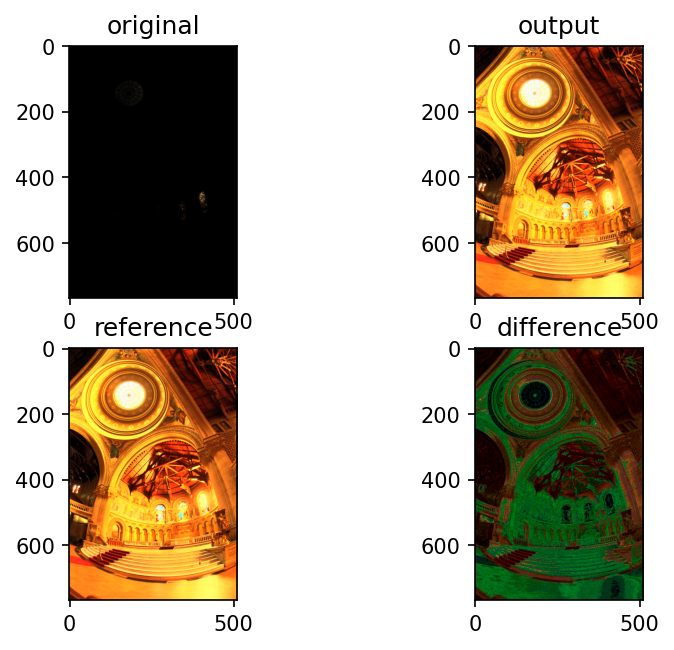

In [ ]:
# plot output images
import matplotlib.pyplot as plt
_,ax = plt.subplots(2,2, dpi=150)

ax[0][0].imshow(plt.imread("../src/HW3/memorial_raw_large.png"))
ax[0][0].set_title("original")
ax[0][0].grid(False)

ax[0][1].imshow(plt.imread("HW3_output.png"))
ax[0][1].set_title("output")
ax[0][1].grid(False)

ax[1][0].imshow(plt.imread("HW3_reference.png"))
ax[1][0].set_title("reference")
ax[1][0].grid(False)

ax[1][1].imshow(plt.imread("HW3_differenceImage.png"))
ax[1][1].set_title("difference")
ax[1][1].grid(False)

plt.show()

Notas:
* Del archivo /content/udacity-cs344-colab/src/CMakeLists.txt, se cambió la linea 24 por: -Wno-deprecated-gpu-targets
* Del archivo /content/udacity-cs344-colab/build/HW3/CMakeFiles/HW3.dir/HW3_generated_student_func.cu.o.cmake, se cambió la linea 76 por: -Wno-deprecated-gpu-targets
* Del archivo /content/udacity-cs344-colab/build/HW3/CMakeFiles/HW3.dir/HW3_generated_student_func.cu.o.cmake.pre-gen, se cambió la linea 76 por: -Wno-deprecated-gpu-targets
* Del archivo /content/udacity-cs344-colab/src/HW3/loadSaveImage.cpp, se cambió de la linea 17 CV_LOAD_IMAGE_COLOR por cv::IMREAD_COLOR
* Del archivo /content/udacity-cs344-colab/src/HW3/loadSaveImage.cpp, se cambió de la linea 17 CV_LOAD_IMAGE_ANYDEPTH por cv::IMREAD_ANYDEPTH
* Del archivo /content/udacity-cs344-colab/src/HW3/loadSaveImage.cpp, se cambió de la linea 56 CV_LOAD_IMAGE_COLOR por cv::IMREAD_COLOR
* Del archivo /content/udacity-cs344-colab/src/HW3/loadSaveImage.cpp, se cambió de la linea 73 CV_BGR2RGBA por cv::COLOR_BGR2RGBA
* Del archivo /content/udacity-cs344-colab/src/HW3/loadSaveImage.cpp, se cambió de la linea 98 CV_RGBA2BGR por cv::COLOR_RGBA2BGR